In [114]:
# First of all, we load the model
import cobra

# moel from Lieven, C., Petersen, L. A., Jørgensen, S. B., Gernaey, K. V., Herrgard, M. J., & Sonnenschein, N. (2018). 
# A genome-scale metabolic model for Methylococcus capsulatus (Bath) suggests reduced efficiency electron transfer to the particulate methane monooxygenase. Frontiers in microbiology, 9, 2947.
met = cobra.io.read_sbml_model("./data/iMcBath_rewritten.xml")

In [32]:
# look at the optimal Biomass production/growth with default parameters
met.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.01244,0,0.00%
ch4_e,EX_ch4_e,18.46,1,100.00%
cl_e,EX_cl_e,0.03817,0,0.00%
cobalt2_e,EX_cobalt2_e,1.027E-05,0,0.00%
cu2_e,EX_cu2_e,0.000269,0,0.00%
fe2_e,EX_fe2_e,0.00109,0,0.00%
h_e,EX_h_e,1.458,0,0.00%
k_e,EX_k_e,0.03142,0,0.00%
mg2_e,EX_mg2_e,0.02198,0,0.00%
mn2_e,EX_mn2_e,3.205E-06,0,0.00%


It is clearly seen that in M. capsulatus the uptake of methane outstands among all the other uptakes. Thus, now we will check those reactions where methane is involved. Besides, we will also check the methanol-involved reactions as it is here where our main interest is placed.

The uptake rate for methane in iMcBath was constrained to 18.46 mmol gDW-1 h-1, a value adopted from de la Torre et al. (2015) due to the lack of a specific measurement for M. capsulatus (Bath).

In [113]:
# check reactions where methane is involved
print(met.reactions.query("methane","name"))
print(met.reactions.query("Methane","name"))
print(met.reactions.query("CH4","name"))

[<Reaction CH4tex at 0x20859b91e08>, <Reaction EX_ch4_e at 0x20859ca8648>]
[<Reaction PMMODCipp at 0x2085a085508>, <Reaction PMMOipp at 0x2085a085588>, <Reaction SMMOi at 0x2085a162b48>]
[<Reaction CH4trpp at 0x20859b94348>]


In [51]:
# the methane uptake reaction (where the constraints are applied) is 
met.reactions.EX_ch4_e

Reaction identifier,EX_ch4_e
Name,methane exchange
Memory address,0x0208540a9348
Stoichiometry,ch4_e <-- methane <--
GPR,
Lower bound,-18.46
Upper bound,0.0


In [37]:
# this is the diffusion of methane from extracellular space to periplasm
met.reactions.CH4tex

Reaction identifier,CH4tex
Name,methane transport via diffusion (extracellular to periplasm)
Memory address,0x07ff513ece9a0
Stoichiometry,ch4_e <=> ch4_p methane <=> methane
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [38]:
# this is the diffusion reation of methane from periplasm to cytosol
met.reactions.CH4trpp 

Reaction identifier,CH4trpp
Name,Diffusion CH4 between Periplasm and Cytosol
Memory address,0x07ff513ec3c40
Stoichiometry,ch4_p <=> ch4_c methane <=> methane
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [40]:
# these are the three methane oxygenase reactions
print(met.reactions.SMMOi)
print(met.reactions.PMMOipp)
print(met.reactions.PMMODCipp)

SMMOi: ch4_c + h_c + nadh_c + o2_c --> h2o_c + meoh_c + nad_c
PMMOipp: ch4_p + o2_p + q8h2_im --> h2o_p + meoh_p + q8_im
PMMODCipp: ch4_p + 2.0 focytcc555_p + 2.0 h_p + o2_p --> 2.0 ficytcc555_p + h2o_p + meoh_p


In [115]:
# we only want pMMO as we do not have an sMMO in Pheast
# from Lieven, Christian, et al. 2018, where the model is obtained, three different hypotheses are conideres, but we will just
# consider the one for PMMOipp, without Direct Coupling, as it seems to be the most supported in the literature
met.reactions.SMMOi.bounds = 0, 0
met.reactions.PMMOipp.bounds = 0, 1000.0 # which were 0 before
met.reactions.PMMODCipp.bounds = 0, 0 

In [21]:
# ubiquinol is our electron donor
met.metabolites.q8h2_im

Metabolite identifier,q8h2_im
Name,Ubiquinol-8
Memory address,0x020850d22d48
Formula,C49H76O4
Compartment,im
In 10 reaction(s),"NADH5ppi, PMMOipp, DMQMT, NADHNQR2ipp, FALDDHipp, NADH16pp, CYOR_q8ppi, BIOMASS_Mcapsulatus, PAMMOipp, NO3R1"


In [14]:
# as mentioned, this is the reaction considered
met.reactions.PMMOipp

Reaction identifier,PMMOipp
Name,particulate Methane Monooxygenase
Memory address,0x020851d63608
Stoichiometry,ch4_p + o2_p + q8h2_im --> h2o_p + meoh_p + q8_im methane + dioxygen + Ubiquinol-8 --> H2O + methanol + Ubiquinone-8
GPR,( ( MCA1796 and MCA1797 and MCA1798 ) or ( MCA2853 and MCA2854 and MCA2855 ) ) and MCA0295
Lower bound,0.0
Upper bound,0.0


In [116]:
# growth with pMMO is better. We figured that once pMMO is active, it takes all of the available methane as
# growth does not change if sMMO is active concurrently with pMMO. the direct coupling pMMO reaction also takes
# all of the methane if other pMMO reaction is active

met.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.01244,0,0.00%
ch4_e,EX_ch4_e,18.46,1,100.00%
cl_e,EX_cl_e,0.03817,0,0.00%
cobalt2_e,EX_cobalt2_e,1.027E-05,0,0.00%
cu2_e,EX_cu2_e,0.000269,0,0.00%
fe2_e,EX_fe2_e,0.00109,0,0.00%
h_e,EX_h_e,1.458,0,0.00%
k_e,EX_k_e,0.03142,0,0.00%
mg2_e,EX_mg2_e,0.02198,0,0.00%
mn2_e,EX_mn2_e,3.205E-06,0,0.00%


In [117]:
# now we will introduce the heterologous protein leghemoglobin with reactions for dna replication,
# transcription and translation
# as the sequences are long, we calculate the stoichiometry with a script which is on the github repo

# make new reactions



hemo_DNA_reaction = cobra.Reaction(
            'r_hemo_DNA',
            name = 'hemoglobin DNA replication',
            lower_bound = 0.0,
            upper_bound = 1000.0
        )

hemo_RNA_reaction = cobra.Reaction(
            'r_hemo_RNA',
            name = 'hemoglobin transcription',
            lower_bound = 0.0,
            upper_bound = 1000.0
        )

hemo_AA_reaction = cobra.Reaction(
            'r_hemo_protein',
            name = 'hemoglobin translation',
            lower_bound = 0.0,
            upper_bound = 1000.0
)


hemo_Biosynthesis = cobra.Reaction(
            'hemo_Biosynthesis',
            name = 'hemoglobin Biosynthesis',
            lower_bound = 0.0,
            upper_bound = 1000.0
)


periplasm_hemo_reaction = cobra.Reaction(
            'c_hemo_p',
            name = 'exchange of hemo_c --> hemo_p',
            lower_bound = 0,
            upper_bound = 1000.0
)

Take_Out_Hemo = cobra.Reaction(
            'Take_Out_Hemo',
            name = 'Take_Out_Hemo',
            lower_bound = 0,
            upper_bound = 1000.0
)


EX_hemo = cobra.Reaction(
            'EX_hemo',
            name = 'hemoglobin exchange reaction',
            lower_bound = -1000.0,
            upper_bound = 1000.0
)

# add the metabolites to be produced by these reactions


hemo_DNA = cobra.Metabolite(
    'hemo_DNA',
    formula='',
    name='Hemo_DNA',
    compartment='c')

hemo_RNA = cobra.Metabolite(
    'hemo_RNA',
    formula='',
    name='Hemo_RNA',
    compartment='c')

hemo_AA = cobra.Metabolite(
    'hemo_AA',
    formula='',
    name='Leghemoglobin',
    compartment='c')

hemo_c = cobra.Metabolite(
    'hemo_c',
    formula='',
    name='hemo_c',
    compartment='c')

hemo_e = cobra.Metabolite(
    'hemo_e',
    formula='',
    name='hemo_e',
    compartment='e')

hemo_p = cobra.Metabolite(
    'hemo_p',
    formula='',
    name='hemo_p',
    compartment='p')


met.add_metabolites([hemo_p,
                     hemo_c,
                     hemo_e,
                     hemo_DNA,
                     hemo_RNA,
                     hemo_AA])



# add involved metabolites and stoichiometry



hemo_DNA_reaction.add_metabolites(
    {
        ### deoxynucleotides
        # A
        met.metabolites.adn_c: -1.0424,
        # T
        met.metabolites.thym_c: -1.0424,
        # C
        met.metabolites.csn_c: -0.57636,
        # G
        met.metabolites.gua_c: -0.57636,
        # ATP
        met.metabolites.atp_c: -11.00757,
        # H2O
        met.metabolites.h2o_c: -11.00757,
        # Hemo_DNA
        met.metabolites.hemo_DNA: 1.0,
        # ADP
        met.metabolites.adp_c: 11.00757,
        # Phosphate
        met.metabolites.pi_c: 11.00757
    }
)

hemo_RNA_reaction.add_metabolites(
    {
        ### RNA nucleotides
        # A
        met.metabolites.adn_c: -1.2408,
        # U
        met.metabolites.ura_c: -0.80329,
        # C
        met.metabolites.csn_c: -0.6455,
        # G
        met.metabolites.gua_c: -0.43034,
        # ATP
        met.metabolites.atp_c: -7.48783,
        # H2O
        met.metabolites.h2o_c: -7.48783,
        # Hemo_RNA
        met.metabolites.hemo_RNA: 1.0,
        # ADP
        met.metabolites.adp_c: 7.48783,
        # Phosphate
        met.metabolites.pi_c: 7.4878
    }
)

hemo_AA_reaction.add_metabolites(
    {
        ### Amino Acids
        # A
        met.metabolites.ala__L_c: -1.48373,
        # C, no Cystein in leghemoglobin
        # pheast.metabolites.cys__L_c:,
        # H
        met.metabolites.gln__L_c: -0.12902,
        # M
        met.metabolites.met__L_c: -0.06451,
        # T
        met.metabolites.thr__L_c: -0.38706,
        # R
        met.metabolites.arg__L_c: -0.06451,
        # E
        met.metabolites.glu__L_c: -0.6451,
        # I
        met.metabolites.ile__L_c: -0.38706,
        # F
        met.metabolites.phe__L_c: -0.58059,
        # W
        met.metabolites.trp__L_c: -0.12902,
        # N
        met.metabolites.asn__L_c: -0.25804,
        # Q
        met.metabolites.gln__L_c: -0.32255,
        # L
        met.metabolites.leu__L_c: -0.83863,
        # P
        met.metabolites.pro__L_c: -0.32255,
        # Y
        met.metabolites.tyr__L_c: -0.19353,
        # D
        met.metabolites.arg__L_c: -0.51608,
        # G
        met.metabolites.gly_c: -0.51608,
        # K
        met.metabolites.lys__L_c: -0.90314,
        # S
        met.metabolites.ser__L_c: -0.83863,
        # V
        met.metabolites.val__L_c: -0.77412,
        # ATP
        met.metabolites.atp_c: -40.22199,
        # H2O
        met.metabolites.h2o_c: -40.22199,
        # Leghemoglobin
        met.metabolites.hemo_c: 1.0,
        # ADP
        met.metabolites.adp_c: 40.22199,
        # Phosphate
        met.metabolites.pi_c: 40.22199
    }
)



hemo_Biosynthesis.add_metabolites(
    {
        met.metabolites.hemo_DNA: -2.8e-05,
        
        met.metabolites.hemo_RNA: -0.0029,
        
        met.metabolites.hemo_AA: -0.997,

        met.metabolites.hemo_c: 1.0,
    }
)

# cytosol --> periplas

periplasm_hemo_reaction.add_metabolites(
    {
        met.metabolites.hemo_c: -1.0,
        
        met.metabolites.hemo_p: 1.0
    }
)

# periplasm --> extracellular

Take_Out_Hemo.add_metabolites(
    {
        met.metabolites.hemo_p: -1.0,

        met.metabolites.hemo_e: 1.0
    }
)

# take it out of extracelllular space


EX_hemo.add_metabolites(
    {            
        met.metabolites.hemo_e : -1.0
    }
)


# add reactions to model

met.add_reactions([#hemo_DNA_reaction,
                   #hemo_RNA_reaction,
                   hemo_AA_reaction,
                   #hemo_Biosynthesis,
                   periplasm_hemo_reaction,
                   Take_Out_Hemo,
                   EX_hemo])

In [118]:
# One option is to once we have the protein production reaction, optimize that reaction
met.objective = met.problem.Objective(met.reactions.r_hemo_protein.flux_expression)
met_final = met.copy()
met_final.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ch4_e,EX_ch4_e,18.46,1,100.00%
h_e,EX_h_e,6.693,0,0.00%
no3_e,EX_no3_e,1.543,0,0.00%
o2_e,EX_o2_e,27.8,0,0.00%
so4_e,EX_so4_e,0.008079,0,0.00%
Metabolite,Reaction,Flux,C-Number,C-Flux
h2o2_c,DM_h2o2_c,-0.05655,0,0.00%
co2_e,EX_co2_e,-12.76,1,100.00%
h2o_e,EX_h2o_e,-31.92,0,0.00%
hemo_e,EX_hemo,-0.1252,0,0.00%


In [119]:
cobra.summary.MetaboliteSummary(metabolite = met_final.metabolites.hemo_c, model = met_final)

Percent,Flux,Reaction,Definition
100.00%,0.1252,r_hemo_protein,1.48373 ala__L_c + 0.51608 arg__L_c + 0.25804 asn__L_c + 40.22199 atp_c + 0.32255 gln__L_c + 0.6451 glu__L_c + 0.51608 gly_c + 40.22199 h2o_c + 0.38706 ile__L_c + 0.83863 leu__L_c + 0.90314 lys__L_c + 0.06451 met__L_c + 0.58059 phe__L_c + 0.32255 pro__L_c + 0.83863 ser__L_c + 0.38706 thr__L_c + 0.12902 trp__L_c + 0.19353 tyr__L_c + 0.77412 val__L_c --> 40.22199 adp_c + hemo_c + 40.22199 pi_c
Percent,Flux,Reaction,Definition
100.00%,-0.1252,c_hemo_p,hemo_c --> hemo_p


In [121]:
cobra.summary.reaction_summary.ReactionSummary(reaction = met_final.reactions.r_hemo_protein, model = met_final)

In [123]:
# However the procedure used in original paper: 
# Irani ZA, Kerkhoven EJ, Shojaosadati SA, Nielsen J (2016) Genome-scale metabolic model of Pichia pastoris with native and humanized glycosylation of recombinant proteins. Biotechnol Bioeng 113:961–969. doi: 10.1002/bit.25863.
# the procedure is first optimize for the growth, and then use this value as constrain in the next optimization of protein production
met_growth_constraint = met.copy()
met_growth_constraint.objective = met_growth_constraint.problem.Objective(met_growth_constraint.reactions.BIOMASS_Mcapsulatus.flux_expression)
met_growth_constraint.reactions.BIOMASS_Mcapsulatus.bounds = met_growth_constraint.optimize().objective_value, met_growth_constraint.optimize().objective_value

In [124]:
# and once constrained, we optimize the protein production reaction 
# but with this approach our model is unable to keep the optimal growth and produce recombinant proteins at the same time)
# (which makes sense to us)
met_growth_constraint.objective = met_growth_constraint.problem.Objective(met_growth_constraint.reactions.r_hemo_protein.flux_expression)
met_growth_constraint.summary()

Metabolite,Reaction,Flux,C-Number,C-Flux
ca2_e,EX_ca2_e,0.01244,0,0.00%
ch4_e,EX_ch4_e,18.46,1,100.00%
cl_e,EX_cl_e,0.03816,0,0.00%
cobalt2_e,EX_cobalt2_e,1.027E-05,0,0.00%
cu2_e,EX_cu2_e,0.0002689,0,0.00%
fe2_e,EX_fe2_e,0.001089,0,0.00%
h_e,EX_h_e,1.458,0,0.00%
k_e,EX_k_e,0.03141,0,0.00%
mg2_e,EX_mg2_e,0.02197,0,0.00%
mn2_e,EX_mn2_e,3.204E-06,0,0.00%


## Plotting image plots

In [125]:
import numpy as np
import matplotlib.pyplot as plt
# we create a function to see how our protein production is optimize on different environments
def image_plot(model, precision, max_met, max_ox):
    plot = np.zeros([precision, precision])
    methane_vec = np.linspace(0,max_met,precision); oxygen_vec = np.linspace(0,max_ox,precision)
    for count_ox, oxygen in enumerate(oxygen_vec):
        for count_met, met in enumerate(methane_vec):
            #print(met, oxygen)
            model.reactions.EX_o2_e.bounds = -oxygen, -oxygen
            model.reactions.EX_ch4_e.bounds = -met, -met 
            result = model.optimize().objective_value
            #print(result)
            if result < 0: 
                result = 0
            plot[(precision-1 - count_ox), count_met] = result
    label_met = np.round(np.linspace(0, max_met, 6),1)
    label_ox = np.round(np.linspace(max_ox, 0,6),1)
    ticks = np.linspace(0, precision - 1,6)
    imgplot = plt.imshow(plot)
    plt.colorbar()
    #plt.gca().invert_yaxis()
    plt.title("Optimization of protein production on different environment uptake")
    plt.xlabel("Methane uptake")
    plt.ylabel("Oxygen uptake")
    plt.xticks(ticks, label_met)
    plt.yticks(ticks, label_ox)
    plt.grid()
    return plot

C:\Users\s202562\AppData\Roaming\Python\Python37\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)


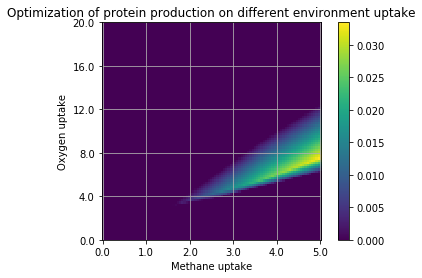

In [127]:
max_met = 5; max_ox = 20; precision = 100
plot = image_plot(met_final, precision, max_met, max_ox)

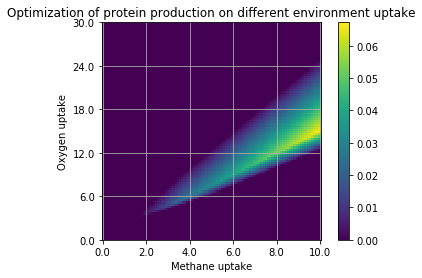

In [84]:
max_met = 10; max_ox = 30; precision = 100
plot = image_plot(met, precision, max_met, max_ox)